In [2]:
import pathlib
from skimage.io import imread, imsave, imshow
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as patches
% matplotlib inline
# process xml file
import xml.etree.ElementTree

In [9]:
# Glob the training data and load a single image path
training_img_paths = pathlib.Path('../../').glob('*/images_png/*.png')
training_img_sorted = sorted([x for x in training_img_paths])

# mask and xml files
training_mask_paths = pathlib.Path('../../').glob('*/pix_annotations_png/*.png')
training_mask_sorted = sorted([x for x in training_mask_paths])

training_xml_paths = pathlib.Path('../../').glob('*/xml_annotations/*.xml')
training_xml_sorted = sorted([x for x in training_xml_paths])

im_path = training_img_sorted[0]
mask_path = training_mask_sorted[0]
xml_path = training_xml_sorted[0]
print(im_path)
print(len(training_img_sorted))
print(mask_path)
print(xml_path)
im = imread(str(im_path))
mask = imread(str(mask_path))
root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
size = root.findall('size')
width = float(size[0][0].text)
height = float(size[0][1].text)

../../DeepScores_archive0/images_png/lg-100016039-aug-beethoven--page-4.png
10000
../../DeepScores_archive0/pix_annotations_png/lg-100016039-aug-beethoven--page-4.png
../../DeepScores_archive0/xml_annotations/lg-100016039-aug-beethoven--page-4.xml


NameError: name 'xml' is not defined

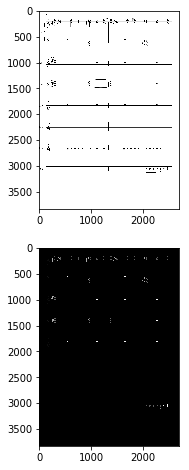

In [6]:
# show the image and mask to check they are consistent
plt.figure(figsize = (6, 8))
plt.subplot(211)
plt.imshow(im)

plt.subplot(212)
plt.imshow(mask, cmap = 'gray')

In [7]:
# process xml file
import xml.etree.ElementTree

In [49]:
# get the information of all symbols in one image
def get_symbol_info(xml_path):
    root = xml.etree.ElementTree.parse(str(xml_path)).getroot()
    size = root.findall('size')
    width = float(size[0][0].text)
    height = float(size[0][1].text)

    symbols = []
    symbol_names = set() # use a set to store unique symbol names
    rectangles = []

    # get the bounding box for each object, multiply with its width and height to get the real pixel coords
    for symbol in root.findall('object'):
        name = symbol.find('name').text
        xmin = round(float(symbol.find('bndbox')[0].text)*width)
        xmax = round(float(symbol.find('bndbox')[1].text)*width)
        ymin = round(float(symbol.find('bndbox')[2].text)*height)
        ymax = round(float(symbol.find('bndbox')[3].text)*height)

        current_rectangle = name, (xmin, ymin), xmax - xmin, ymax - ymin
        current_symbol = name, xmin, xmax, ymin, ymax, height, width
        rectangles.append(current_rectangle)
        symbols.append(current_symbol)
        symbol_names.add(name)
    return symbols, symbol_names, rectangles

2707.0 3828.0
There are 104 symbols in the score


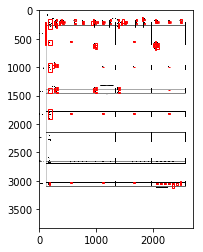

In [47]:
# draw the bounding box to make sure the coordinates extracted are correct
# Create figure and axes
plt.figure(figsize = (12, 20))
fig,ax = plt.subplots(1)

symbols, symbol_names, rectangles = get_symbol_info(xml_path)

# Display the image
ax.imshow(im)
print('There are %d symbols in the score' % len(rectangles))
for rectan in rectangles:
    # Create a Rectangle patch
    rect = patches.Rectangle(rectan[1],rectan[2],rectan[3],linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()

In [15]:
# symbolprops = regionprops(labels)
# print(len(symbolprops))
# for symbolprop in symbolprops:
#     print(symbolprop.bbox_area)

symbols_sorted = sorted(symbols, key=lambda element: (element[1], element[2], element[4], element[4]))
print(symbols_sorted)

[('brace', 99, 122, 204, 615, 3828.0, 2707.0), ('fClef', 147, 212, 522, 601, 3828.0, 2707.0), ('fClef', 147, 212, 1373, 1451, 3828.0, 2707.0), ('gClef', 151, 213, 159, 332, 3828.0, 2707.0), ('gClef', 151, 213, 919, 1092, 3828.0, 2707.0), ('gClef', 151, 213, 1736, 1909, 3828.0, 2707.0), ('unpitchedPercussionClef1', 166, 193, 3029, 3075, 3828.0, 2707.0), ('accidentalSharp', 226, 251, 954, 1022, 3828.0, 2707.0), ('accidentalSharp', 256, 281, 194, 262, 3828.0, 2707.0), ('accidentalSharp', 256, 281, 920, 988, 3828.0, 2707.0), ('accidentalSharp', 256, 281, 1362, 1430, 3828.0, 2707.0), ('noteheadBlack', 289, 317, 158, 183, 3828.0, 2707.0), ('noteheadBlack', 289, 317, 215, 240, 3828.0, 2707.0), ('noteheadWhole', 289, 329, 941, 967, 3828.0, 2707.0), ('noteheadWhole', 289, 329, 976, 1001, 3828.0, 2707.0), ('noteheadWhole', 289, 329, 1349, 1375, 3828.0, 2707.0), ('noteheadWhole', 289, 329, 1384, 1409, 3828.0, 2707.0), ('noteheadWhole', 289, 329, 1429, 1455, 3828.0, 2707.0), ('flag8thDown', 290, 3

In [22]:
# generate different mask for each single symbol
# labels, nlabels = ndimage.label(mask)
# print(np.min(labels), np.max(labels))

# label_arrays = []
# for label_num in range(1, nlabels+1):
#     label_mask = np.where(labels == label_num, 1, 0)
#     label_arrays.append(label_mask)

# print('There are %d separate components.' % (nlabels))
# imshow(labels)

# build masks for individual symbol
masks = np.zeros((int(height), int(width), len(symbols)), dtype=np.uint8)
class_dict = []
for i, symbol in enumerate(symbols):
    # draw a rectangle of ones on a blank image mask
    # coords are row, col, so we should put (y, x), instead of (x, y)
    xmin, xmax, ymin, ymax = symbol[1], symbol[2], symbol[3], symbol[4]
#     # r & c are coords of vertices of the rectangle
#     r = np.array([ymin-1, ymin-1, ymax+1, ymax+1, ymin-1])
#     c = np.array([xmin-1, xmax+1, xmax+1, xmin-1, xmin-1])
#     rr, cc = polygon(r, c) 
#     temp_mask[rr, cc] = 1
    masks[ymin:ymax+1, xmin:xmax+1, i] = mask[ymin:ymax+1, xmin:xmax+1]
    class_dict.append(symbol[0])

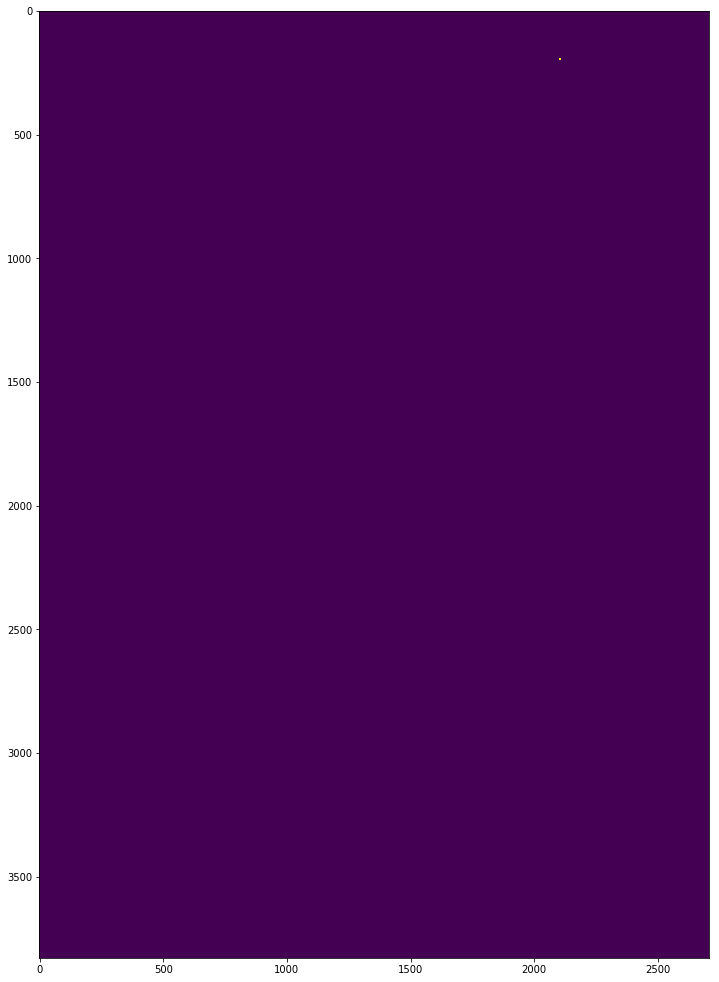

In [23]:
plt.figure(figsize=(12,18))
plt.imshow(masks[:,:,12])

In [26]:
class_dict = {}
symbol_type = set()
# form a universal symbol set fot the whole dataset, this can take 3 ~ 5 min
for xml_path in training_xml_sorted:
    _, symbol_names,_ = get_symbol_info(xml_path)
    symbol_type = symbol_type.union(symbol_names)

In [28]:
print('Total number of symbols in the dataset:', len(symbol_type))
# assign integer numbers for each symbol class
i = 0
for item in symbol_type:
    class_dict[item] = i
    i += 1
print(class_dict['fClef'])

Total number of symbols in the dataset: 114
67


In [33]:
# save the symbol_type set for convenience
np.save('symbol_type.npy', symbol_type) 

# Load
read_symbol_type = np.load('symbol_type.npy').item()
print(len(read_symbol_type))
print(read_symbol_type)

114
{'restQuarter', 'accidentalSharpSmall', 'keyboardPedalPed', 'dynamicMF', 'articMarcatoBelow', 'accidentalNatural', 'noteheadDoubleWhole', 'flag8thDown', 'fermataBelow', 'noteheadHalf', 'articTenutoBelow', 'flag16thDown', 'segno', 'repeatDot', 'timeSig5', 'keyboardPedalUp', 'dynamicPiano', 'ornamentTurnInverted', 'tuplet6', 'dynamicFortePiano', 'gClefChange', 'timeSig1', 'flag16thUp', 'rest128th', 'noteheadWhole', 'brace', 'keySharp', 'articMarcatoAbove', 'dynamicPPPP', 'timeSig4', 'coda', 'clef8', 'timeSig7', 'rest64th', 'fClef', 'articStaccatissimoBelow', 'timeSig6', 'flag64thDown', 'restWhole', 'caesura', 'dynamicSforzato', 'fingering0', 'ornamentTurn', 'fermataAbove', 'dynamicMP', 'accidentalFlat', 'fClefChange', 'cClefAltoChange', 'accidentalDoubleSharp', 'accidentalFlatSmall', 'cClefTenor', 'noteheadBlackSmall', 'keyFlat', 'dynamicForte', 'dynamicPP', 'flag128thDown', 'articStaccatissimoAbove', 'dynamicPPPPP', 'augmentationDot', 'flag32ndDown', 'articAccentAbove', 'timeSig0', 

# Mask R-CNN for DeepScore

## Dataset Class

In [36]:
from mrcnn import utils
class ScoreDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_score(self, img_sorted):
        """Load a subset of the DeepScore dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
    
        for key, value in class_dict.items():
            self.add_class("symbol", value, key)
        # Train or validation dataset?      
        img_sorted = sorted([x for x in dataset_dir])
        
        # add images
        for i, image_path in enumerate(img_sorted):
            image = imread(str(im_path))
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            
            self.add_image(
                "balloon",
                image_id=i,
                path=image_path,
                width=width, height=height)
        

    def image_reference(self, image_id):
        """Return the score data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "symbol":
            return info["symbol"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id, xml_sorted):
        """Generate instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """        
        image_info = self.image_info[image_id]
        if image_info["source"] != "symbol":
            return super(self.__class__, self).load_mask(image_id)

        # image_id == xml_id
        xml_path = xml_sorted[image_id]
        symbols, symbol_names, _ = get_symbol_info(s)
        masks = np.zeros([info['height'], info['width'], len(symbols)], dtype=np.uint8)
        for i, symbol in enumerate(symbols):
            # draw a rectangle of ones on a blank image mask
            # coords are row, col, so we should put (y, x), instead of (x, y)
            xmin, xmax, ymin, ymax = symbol[1], symbol[2], symbol[3], symbol[4]
            masks[ymin:ymax+1, xmin:xmax+1, i] = mask[ymin:ymax+1, xmin:xmax+1]
        
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in symbols])
            
        
        return mask.astype(np.bool), class_ids.astype(np.int32)



/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [51]:
## Split dataset into training and validation
split = 8000
train_img_data = training_img_sorted[:8000]
val_img_data = training_img_sorted[8000:]

train_xml_data = training_xml_sorted[:8000]
val_xml_data = training_img_sorted[8000:]

10000


In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = ScoreDataset()
    dataset_train.load_score(train_img_data)
    dataset_train.prepare()

    # Validation dataset
    dataset_val = ScoreDataset()
    dataset_val.load_score(train_xml_data)
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')